## Pre-requisites and getting started

In [81]:
#If plotly or sklearn or whichever needed package is not installed on your system you will need to run this command first (remove the # first)
#!pip install plotly
#!pip install scikit-learn

#If any of the pip install code is not correctly written, read the output and adjust, for example, sklrean needs to be scikit-learn to work

In [82]:
#In rare cases, if your system does not have pandas installed, you may need to run this command to address that
#!pip install pandas

In [83]:
#The import code below is needed to run downstream info
#You must run this

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import random

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from matplotlib.patches import Patch

import plotly.express as px
from sklearn.decomposition import PCA
from matplotlib.patches import Patch

## Loading in csv 

In [84]:
#This command loads a csv file that should have at least the Sample ID, Site, SNP, G_Annotation, VAF, and whether the sample is individual or pooled
#Replace the NameOfFile.csv part with the name of your file. If the file is not in the same directory as this Jupyter Notebook, you will need to specify the path length, within the quotes, as well as the name at the end of the path length (all within the quotes)

StudySNPs=pd.read_csv('NGSresults.csv')

#The command below will remove the period, any values after the period, and the percentage symbol within the VAF column. The heatmap takes whole numbers and they cannot be a percentage.
#This command should only be run as needed, but even if non-decimal, non-percentage type of data is present within VAF, this command can still be run as it would not perform any manipulation, and thereby the end result would be the same as not running it
StudySNPs['VAF'] = StudySNPs['VAF'].str.replace(r'.\d*%', '', regex=True) 


In [85]:
#This command shows a preview of the loaded csv file. This is good to know to make sure the file loaded correctly, but also that the information present within the file is organized as expected and has, at least in the first few rows, the correct type of information

print(StudySNPs.head())

       StudyID   GENE REGION Site DISTRICT  TREATMENT_DAY      POOLED  YEAR  \
0  ACH21-AA003  Pfcrt   Afar  AMI  Amibara              0  individual    21   
1  ACH21-AA003  Pfcrt   Afar  AMI  Amibara              0  individual    21   
2  ACH21-AA003  Pfcrt   Afar  AMI  Amibara              0  individual    21   
3  ACH21-AA003  Pfcrt   Afar  AMI  Amibara              0  individual    21   
4  ACH21-AA003  Pfcrt   Afar  AMI  Amibara              0  individual    21   

   COVERAGE  VAF   VF G_ANNOTATION AA_change   SNP      TYPE   SEX   AGE  
0       757  100  757         K76T      K76T   K76  mutation  Male  42.0  
1       508  100  508        A220S     A220S  A220  mutation  Male  42.0  
2       600  100  600        Q271E     Q271E  Q271  mutation  Male  42.0  
3       660  100  660        N326S     N326S  N326  mutation  Male  42.0  
4       681  100  681        R371I     R371I  R371  mutation  Male  42.0  


In [86]:
#This command pulls out only the individually sequenced samples as annotated by the "Individual" label in the "POOLED" column

#IndividualSamplesOnly=StudySNPs[StudySNPs['Individual'] == 'Individual']


#However, if both individual and pooled samples are to be plotted, instead can run this

IndividualSamplesOnly=StudySNPs

In [87]:
#This command is used to create a list of the unique amino acid sites
#At the bottom the ID may be differently named, for example, in the instance where I was writing this, instead of AMD_ID_IND I had used "StudyID" as it was a special case. 
#That is why the AMD_ID_IND containing line was #'d out and the correct one was kept in

#avoid duplicate SNPs in the final heatmap by only recording the original amino acid and the location of the SNP

IndividualSamplesOnly = IndividualSamplesOnly.drop(columns=['SNP'])
IndividualSamplesOnly = IndividualSamplesOnly.rename(columns={'G_ANNOTATION':'SNP'})
IndividualSamplesOnly['SNP'] = IndividualSamplesOnly['SNP'].astype(str)
IndividualSamplesOnly['SNP'] = IndividualSamplesOnly['SNP'].str[:-1] 
#IndividualSamplesOnly = IndividualSamplesOnly.drop_duplicates(subset=['AMD_ID_IND','SITE', 'SNP', 'VAF'])
IndividualSamplesOnly = IndividualSamplesOnly.drop_duplicates(subset=['StudyID','Site', 'SNP', 'VAF'])

In [88]:
#This command shows the unique values from the SNP column we edited earlier. These values should be something like AA###, like R622 in k13 for example

IndividualSamplesOnly.SNP.unique()

array(['K76', 'A220', 'Q271', 'N326', 'R371', 'N51', 'C59', 'S108',
       'A437', 'K540', 'N86', 'R622', 'Y184', 'P441', 'M74', 'N75',
       'I356', 'A581', 'S436', 'A675', 'A578', 'Y268', 'F446', 'G449',
       'N458', 'C469', 'M476', 'A481', 'Y493', 'R515', 'P527', 'N537',
       'G538', 'R539', 'I543', 'P553', 'R561', 'V568', 'P574', 'C580',
       'D584', 'I258', 'A16', 'I164', 'I431', 'A613', 'C72', 'V73', 'T93',
       'H97', 'F145', 'I218', 'M343', 'C350', 'G353', 'S1034', 'N1042',
       'D1246'], dtype=object)

## Creating the SNP-GENE Dictionary

In [89]:
#This command establishes a dictionary that connects each SNP in the file to its corresponding gene and groups them together by gene

SNP_GENE_DICT = IndividualSamplesOnly[['SNP', 'GENE']]
SNP_GENE_DICT = SNP_GENE_DICT.drop_duplicates()
SNP_GENE_DICT = SNP_GENE_DICT.sort_values(by=['GENE'], ascending=True).reset_index(drop=True)

#### The next 6 commands creates an individual SNP-GENE dictionary for each Gene so that we can order the SNPs by where they occur from 3' to 5'

In [90]:
#Pfcrt

Pfcrt_Dict = SNP_GENE_DICT[SNP_GENE_DICT['GENE'].str.contains('Pfcrt')]
Pfcrt_Dict['NucleotideNumber'] = Pfcrt_Dict['SNP'].str.extract('(\d+)', expand=True)
Pfcrt_Dict['NucleotideNumber'] = Pfcrt_Dict['NucleotideNumber'].astype(int)
Pfcrt_Dict = Pfcrt_Dict.sort_values(by=['NucleotideNumber'], ascending=True).reset_index(drop=True)
Pfcrt_Dict = Pfcrt_Dict.drop(['NucleotideNumber'], axis=1)

/tmp/ipykernel_2847034/1583348567.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfcrt_Dict['NucleotideNumber'] = Pfcrt_Dict['SNP'].str.extract('(\d+)', expand=True)
/tmp/ipykernel_2847034/1583348567.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfcrt_Dict['NucleotideNumber'] = Pfcrt_Dict['NucleotideNumber'].astype(int)


In [91]:
#Pfcytb

Pfcytb_Dict = SNP_GENE_DICT[SNP_GENE_DICT['GENE'].str.contains('Pfcytb')]
Pfcytb_Dict['NucleotideNumber'] = Pfcytb_Dict['SNP'].str.extract('(\d+)', expand=True)
Pfcytb_Dict['NucleotideNumber'] = Pfcytb_Dict['NucleotideNumber'].astype(int)
Pfcytb_Dict = Pfcytb_Dict.sort_values(by=['NucleotideNumber'], ascending=True).reset_index(drop=True)
Pfcytb_Dict = Pfcytb_Dict.drop(['NucleotideNumber'], axis=1)

/tmp/ipykernel_2847034/169009293.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfcytb_Dict['NucleotideNumber'] = Pfcytb_Dict['SNP'].str.extract('(\d+)', expand=True)
/tmp/ipykernel_2847034/169009293.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfcytb_Dict['NucleotideNumber'] = Pfcytb_Dict['NucleotideNumber'].astype(int)


In [92]:
#Pfdhfr

Pfdhfr_Dict = SNP_GENE_DICT[SNP_GENE_DICT['GENE'].str.contains('Pfdhfr')]
Pfdhfr_Dict['NucleotideNumber'] = Pfdhfr_Dict['SNP'].str.extract('(\d+)', expand=True)
Pfdhfr_Dict['NucleotideNumber'] = Pfdhfr_Dict['NucleotideNumber'].astype(int)
Pfdhfr_Dict = Pfdhfr_Dict.sort_values(by=['NucleotideNumber'], ascending=True).reset_index(drop=True)
Pfdhfr_Dict = Pfdhfr_Dict.drop(['NucleotideNumber'], axis=1)

/tmp/ipykernel_2847034/3936208337.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfdhfr_Dict['NucleotideNumber'] = Pfdhfr_Dict['SNP'].str.extract('(\d+)', expand=True)
/tmp/ipykernel_2847034/3936208337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfdhfr_Dict['NucleotideNumber'] = Pfdhfr_Dict['NucleotideNumber'].astype(int)


In [93]:
#Pfdhps

Pfdhps_Dict = SNP_GENE_DICT[SNP_GENE_DICT['GENE'].str.contains('Pfdhps')]
Pfdhps_Dict['NucleotideNumber'] = Pfdhps_Dict['SNP'].str.extract('(\d+)', expand=True)
Pfdhps_Dict['NucleotideNumber'] = Pfdhps_Dict['NucleotideNumber'].astype(int)
Pfdhps_Dict = Pfdhps_Dict.sort_values(by=['NucleotideNumber'], ascending=True).reset_index(drop=True)
Pfdhps_Dict = Pfdhps_Dict.drop(['NucleotideNumber'], axis=1)

/tmp/ipykernel_2847034/1002212794.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfdhps_Dict['NucleotideNumber'] = Pfdhps_Dict['SNP'].str.extract('(\d+)', expand=True)
/tmp/ipykernel_2847034/1002212794.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfdhps_Dict['NucleotideNumber'] = Pfdhps_Dict['NucleotideNumber'].astype(int)


In [94]:
#Pfk13

Pfk13_Dict = SNP_GENE_DICT[SNP_GENE_DICT['GENE'].str.contains('Pfk13')]
Pfk13_Dict['NucleotideNumber'] = Pfk13_Dict['SNP'].str.extract('(\d+)', expand=True)
Pfk13_Dict['NucleotideNumber'] = Pfk13_Dict['NucleotideNumber'].astype(int)
Pfk13_Dict = Pfk13_Dict.sort_values(by=['NucleotideNumber'], ascending=True).reset_index(drop=True)
Pfk13_Dict = Pfk13_Dict.drop(['NucleotideNumber'], axis=1)

/tmp/ipykernel_2847034/3217292573.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfk13_Dict['NucleotideNumber'] = Pfk13_Dict['SNP'].str.extract('(\d+)', expand=True)
/tmp/ipykernel_2847034/3217292573.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfk13_Dict['NucleotideNumber'] = Pfk13_Dict['NucleotideNumber'].astype(int)


In [95]:
#Pfmdr1

Pfmdr1_Dict = SNP_GENE_DICT[SNP_GENE_DICT['GENE'].str.contains('Pfmdr1')]
Pfmdr1_Dict['NucleotideNumber'] = Pfmdr1_Dict['SNP'].str.extract('(\d+)', expand=True)
Pfmdr1_Dict['NucleotideNumber'] = Pfmdr1_Dict['NucleotideNumber'].astype(int)
Pfmdr1_Dict = Pfmdr1_Dict.sort_values(by=['NucleotideNumber'], ascending=True).reset_index(drop=True)
Pfmdr1_Dict = Pfmdr1_Dict.drop(['NucleotideNumber'], axis=1)

/tmp/ipykernel_2847034/3850270403.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfmdr1_Dict['NucleotideNumber'] = Pfmdr1_Dict['SNP'].str.extract('(\d+)', expand=True)
/tmp/ipykernel_2847034/3850270403.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pfmdr1_Dict['NucleotideNumber'] = Pfmdr1_Dict['NucleotideNumber'].astype(int)


In [96]:
#This command combines all the sorted GENE-SNP dictionaries back into one in alphabetical order to maintain original ordering of the genes, and shows a preview of the combined dictionary

SNP_GENE_DICT = pd.concat([Pfcrt_Dict, Pfcytb_Dict, Pfdhfr_Dict, Pfdhps_Dict, Pfk13_Dict, Pfmdr1_Dict], axis=0).reset_index(drop=True)
print(SNP_GENE_DICT.head())

   SNP   GENE
0  C72  Pfcrt
1  V73  Pfcrt
2  M74  Pfcrt
3  N75  Pfcrt
4  K76  Pfcrt


## Making a Pivot Table

In [97]:
#This command will create a pivot table from the imported and filtered indivudal samples data. In this specific command, the index for the pivot table is created using BOTH SampleID AND Region info, if just one is used, instead of index=['column1','column2'] one would write index='column1'
#When creating the pivot table we use the 'fill_value' command to make any blank cells a negative number to account for samples that had no coverage in the final heat map
#The second command will print a preview on here

StudyIndPT = IndividualSamplesOnly.pivot_table(index=['StudyID','Site'], columns=['SNP'], values='VAF', fill_value=-20)
OrderedList = SNP_GENE_DICT['SNP'].to_list()
StudyIndPT = StudyIndPT[OrderedList]
print(StudyIndPT.head())

#The command below will creaete a new pivot table output in your directory for this pivot table
#I have to do this because I cannot figure out how to make the indexes work without essentially recalling these as columns by saving and then loading (next section)

StudyIndPT.to_csv(r'NGSresults_PT_Sorted.csv')


SNP               C72  V73  M74  N75  K76  T93  H97  F145  I218  A220  ...  \
StudyID     Site                                                       ...   
ACH21-AA003 AMI     0    0   97   97  100    0    0     0     0   100  ...   
ACH21-AA004 AMI     0    0   97   97  100    0    0     0     0   100  ...   
ACH21-AA006 AMI     0    0   97   97  100    0    0     0     0   100  ...   
ACH21-AA008 AMI     0    0   97   97  100    0    0     0     0   100  ...   
ACH21-AA010 AMI     0    0   96   96  100    0    0     0     0   100  ...   

SNP               A578  C580  D584  R622  A675  N86  Y184  S1034  N1042  D1246  
StudyID     Site                                                                
ACH21-AA003 AMI      0     0     0     0     0  100     0      0      0      0  
ACH21-AA004 AMI      0     0     0     0     0    0     0      0      0      0  
ACH21-AA006 AMI      0     0     0   100     0    0   100      0      0      0  
ACH21-AA008 AMI      0     0     0     0     0  

## Workaround Setup - Goal is to plot heatmap, label it, and color code the rows by a category (sites) and the columns by a category (genes)

In [98]:
#Here, first task is to load the dataframe (but it will treat the dual indexes a bit differently)

InputPivotFile = pd.read_csv('NGSresults_PT_Sorted.csv')


#For that reason, we need to set the index for our setup file
#Then the print will let us look at the output


InputPivotFile = InputPivotFile.set_index('StudyID')
print(InputPivotFile.head())

# #Now, the ACTUAL file we will plot needs to NOT have the region info. Only the SampleID and the dataframe of values for the SNPs
# #To accomplish this, we drop the Region column. Make sure to drop save the output as a different file. The "_simple" is what we will plot. The non simple is what will be used in setup in the first part next

InputPivotFile_simple = InputPivotFile.drop(columns=['Site'])
print(InputPivotFile_simple.head())



            Site  C72  V73  M74  N75  K76  T93  H97  F145  I218  ...  A578  \
StudyID                                                          ...         
ACH21-AA003  AMI    0    0   97   97  100    0    0     0     0  ...     0   
ACH21-AA004  AMI    0    0   97   97  100    0    0     0     0  ...     0   
ACH21-AA006  AMI    0    0   97   97  100    0    0     0     0  ...     0   
ACH21-AA008  AMI    0    0   97   97  100    0    0     0     0  ...     0   
ACH21-AA010  AMI    0    0   96   96  100    0    0     0     0  ...     0   

             C580  D584  R622  A675  N86  Y184  S1034  N1042  D1246  
StudyID                                                              
ACH21-AA003     0     0     0     0  100     0      0      0      0  
ACH21-AA004     0     0     0     0    0     0      0      0      0  
ACH21-AA006     0     0   100     0    0   100      0      0      0  
ACH21-AA008     0     0     0     0    0   100      0      0      0  
ACH21-AA010     0     0     0    

## Setting up everything for the heatmap - primarily the colors for the "Sites" and the colors for the "Genes"

In [99]:
#This first part sets up the SNP-Gene dictionary and make sure the genes are ordered alphabetically so that the genes and colors show up in the same order on each plot

SNP_GENE_DICT = SNP_GENE_DICT.set_index('SNP')
SNP_GENE_DICT = SNP_GENE_DICT.sort_values(by=['GENE'], ascending=True)

#The second part tells "setup 1&2" to consider labeling by the Site and Gene values.
#Note, this is the non "_simple" file

setup = InputPivotFile.Site
setup2 = SNP_GENE_DICT.GENE

#The following code establishes random colors ("hex codes") according to the number of sites you have in your dataset
#the commented out section is the simple version but may lead to colors being to similar, the section below offers a wider range, but sometimes it create a hex code that is too short and can't be read by the code below so a random number or letter is added to complete the hex code

num_of_sites = (len(setup.unique()))
color_list = [ ]

# for i in range(num_of_sites):
#     color = "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
#     color_list.append(color)

for i in range(num_of_sites):
    color = random.randrange(0, 2**24)
    hex_color = hex(color)
    hex_color = "#" + hex_color[2:]
    if len(hex_color) == 7:
        color_list.append(hex_color)
    else:
        print(len(hex_color))
        hex_color = hex_color+''.join([random.choice('0123456789ABCDEF') for j in range(1)])
        color_list.append(hex_color)

#Finally we create a dictionary that connects each unique site and gene to a unique color for plotting on the heat map    

lut = dict(zip(setup.unique(), color_list))  ##create a dictionary where each unique region has a specific color as a value
row_colors2 = setup.map(lut)   

lut2 = dict(zip(setup2.unique(), ['#ee3d02','#d9ee02', '#02ee11', '#02eee0', '#021fee', '#ee02e8']))  ##create a dictionary where each unique gene has a specific color as a value
col_colors2 = setup2.map(lut2)

# Plotting Heatmap

/opt/tljh/user/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


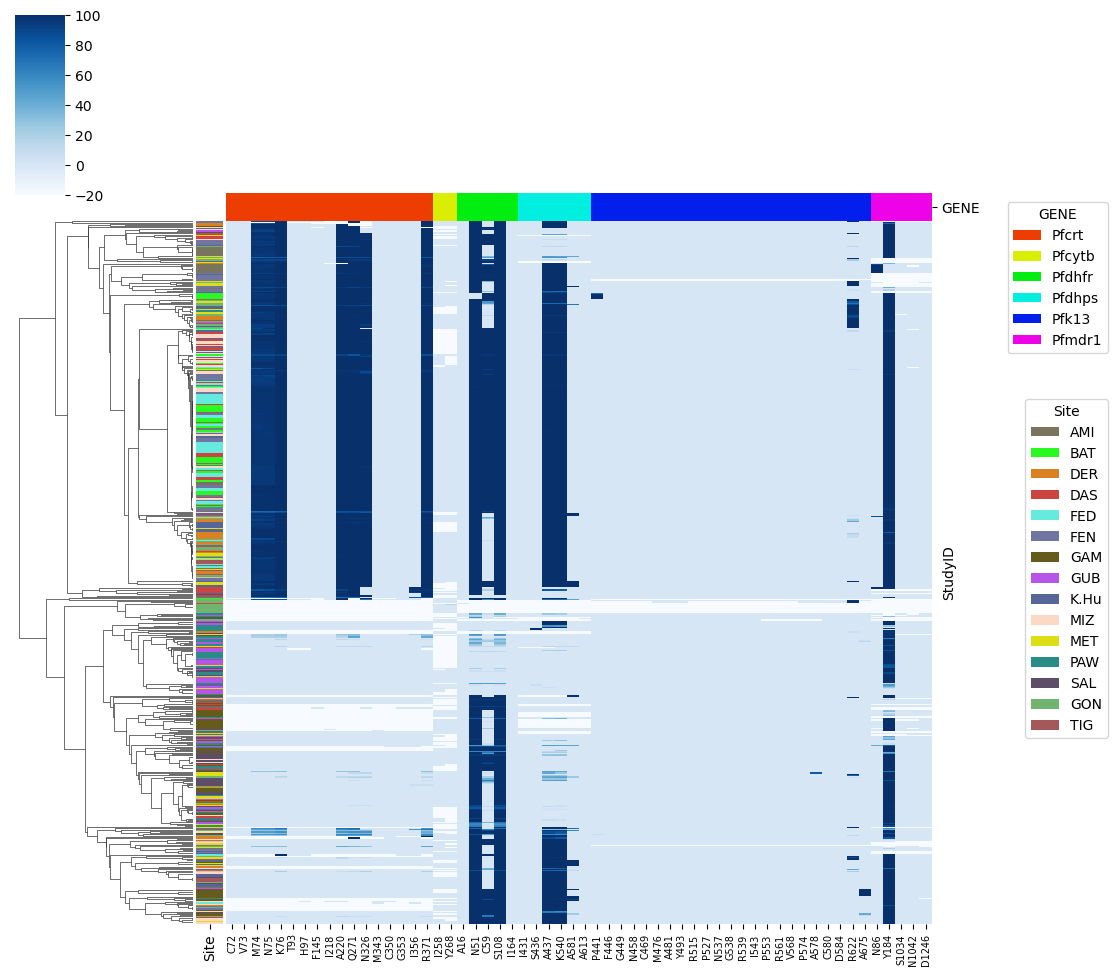

In [100]:
#Finally, the heatmap plotting. Note, the file that is being plotted is the "_simple" datafram
#'col_cluster' is set to False so the order of the genes and SNPs stays ordered; 'row_cluster' is set to true to show the relationship between sites but can be set to false if order needs to be preserved
#'yticklabels' can be set to true if you want to see the SampleID each row corresponds to; 'xticklabels' should be set to true to see the SNP that is being shown in that region of the heatmap

x = sns.clustermap(InputPivotFile_simple, cmap='Blues', row_colors=row_colors2, col_colors=col_colors2, col_cluster=False, row_cluster=True , yticklabels=False, xticklabels=True)
x.ax_heatmap.set_xticklabels(x.ax_heatmap.get_xmajorticklabels(), fontsize = 7)


#This code creates two legends that shows "Genes" and their corresponding colors in the upper right and the "Sites" and their corresponding colors in the lower right

handles = [Patch(facecolor=lut2[name]) for name in lut2]
handles2 = [Patch(facecolor=lut[name]) for name in lut]

plt.legend(handles, lut2, title='GENE',
           bbox_to_anchor=(1.12, .8), bbox_transform=plt.gcf().transFigure, loc='upper right')

x.ax_col_dendrogram.legend(handles2, lut, title='Site', loc="lower right", bbox_to_anchor=(1.12, .25), bbox_transform=plt.gcf().transFigure)


#Finally, this last bit will save the output as a pdf
plt.savefig('NGSresults-Heatmap.pdf', bbox_inches='tight')

## Thoughts on how to use this

This is very simple and rather limited but if you wanted to plot the frequencies of SNPs (or maybe specific microhaplotype makeup, not sure what this would look like) along with hrp2 deletion status, hrp3 deletion status, mdr1 copy number level for many samples and look at how the deletions, CNVs, and other mutations cluster this would be an easy way to see what goes with what. It could be used to drive the labeling of a more informative PCA.

Regarding the mentioned hrp2/3 deletions, mdr1 CNVs: if there is an hrp2 column, along with all the mutation (SNPs) columns, you could have 100% be hrp2 deletion and 0% be not deleted, same for hrp3, and then for mdr1 it could be something like 0% is no duplication and 100% is the maximum amount of duplications observed and the levels from 0-100 indicate to what degree it is duplicated. Just some quick thoughts.

I think in general, this heatmap is slightly better than highlighting values in Excel. The thing that does elevate it beyond that is that the sample (rows) and/or mutations (columns) can cluster based on the frequencies (or whatever values) are prsent and this can be informative, plus it is very quick.

Therefore, this can be a potentially informative first step. 

There are limitations to how many rows and columns can be plotted together before the labels get lost.